In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using SpecialFunctions
using BenchmarkTools
using TransportMap
using QuadGK
using Polynomials
using Distributions
using Random
using LoopVectorization
using Optim
using NLsolve
using MLDataUtils
using MLDataPattern
using Test
using SparseArrays
using AdaptiveTransportMap: vander, transform!, evaluate, ncoeff, optimize, negative_log_likelihood!, derivative

# using Profile
# using ProfileView
using StaticArrays
using QRupdate

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/AN696/src/RecipesBase.jl:117


In [17]:
Nx = 3
Ne = 8
m = 20

idx = [0 0 0; 0 0 1; 0 1 0; 0 1 1; 0 1 2; 1 0 0]


Nψ = 6
coeff = [ 0.20649582065364197;
         -0.5150990160472986;
          2.630096893080717;
          1.13653076177397;
          0.6725837371023421;
         -1.3126095306624133]
coeff0 = deepcopy(coeff)



X =  Matrix([ 1.12488     0.0236348   -0.958426;
         -0.0493163   0.00323509  -0.276744;
          1.11409     0.976117     0.256577;
         -0.563545    0.179956    -0.418444;
          0.0780599   0.371091    -0.742342;
          1.77185    -0.175635     0.32151;
         -0.869045   -0.0570977   -1.06254;
         -0.165249   -2.70636      0.548725]')

L = LinearTransform(X)
transform!(L, X);

# For α = 0.0
C = MapComponent(m, Nx, idx, coeff; α = 0.0)

S = Storage(C.I.f, X);

In [18]:
J = 0.0
dJ = zeros(Nψ)
J = negative_log_likelihood!(J, dJ, coeff, S, C, X)

1.712405808069109

In [6]:
S̃ = Storage(C.I.f, X)
F = QRscaling(S̃);
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

mul!(S̃.ψoffψd0, S̃.ψoffψd0, F.Uinv)
mul!(S̃.ψoffdψxd, S̃.ψoffdψxd, F.Uinv)

@time J̃ = qrnegative_log_likelihood!(J̃, dJ̃, c̃oeff0, F, S̃, C, X)

@show J̃
@show dJ̃

mul!(S̃.ψoffψd0, S̃.ψoffψd0, F.U)
mul!(S̃.ψoffdψxd, S̃.ψoffdψxd, F.U);

  1.913938 seconds (6.37 M allocations: 315.373 MiB, 4.69% gc time)
J̃ = 1.7124058080691076
dJ̃ = [-0.3573017726386752, -0.2653466846284366, -0.2021113509478187, 1.100222638236371, -0.35109216432710877, 1.180787508955647]


In [15]:
dJ̃

6-element Array{Float64,1}:
 -0.3573017726386752
 -0.2653466846284366
 -0.2021113509478187
  1.100222638236371
 -0.35109216432710877
  1.180787508955647

In [16]:
dJ

6-element Array{Float64,1}:
  1.0106020254511265
  0.5795900294742009
  0.5368061292507362
  0.30244842100855623
 -0.015442389781934077
  0.4895928758174947

In [5]:
# Ne = 500
# X = randn(Nx, Ne).*randn(Nx, Ne)

# L = LinearTransform(X)
# transform!(L, X);

# # For α = 0.0
# C = MapComponent(m, Nx, idx, coeff; α = 0.0)

# S = Storage(C.I.f, X);

In [6]:
S.cache_dψxd .= randn(Ne)
S.cache_dcψxdt .= randn(Ne, Nψ)
@time S.cache_dψxd .* (S.cache_dcψxdt * F.Uinv)
@time @avx S.cache_dψxd * (S.cache_dcψxdt *ˡ F.Uinv)

  0.051629 seconds (18.37 k allocations: 996.351 KiB)


LoadError: MethodError: no method matching *(::Array{Float64,1}, ::LoopVectorization.Product{Array{Float64,2},UpperTriangular{Float64,Array{Float64,2}}})
Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...) at operators.jl:538
  *(!Matched::ChainRulesCore.One, ::Any) at /home/mat/.julia/packages/ChainRulesCore/Q5Nrj/src/differential_arithmetic.jl:68
  *(!Matched::ChainRulesCore.DoesNotExist, ::Any) at /home/mat/.julia/packages/ChainRulesCore/Q5Nrj/src/differential_arithmetic.jl:23
  ...

In [7]:
qrnegative_log_likelihood!(J̃, dJ̃, c̃oeff0, F, S̃, C, X)

4.462913513325966

### Old version

In [8]:
S̃ = Storage(C.I.f, X)
F = QRscaling(S̃);
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

mul!(S̃.ψoffψd0, S̃.ψoffψd0, F.Uinv)
mul!(S̃.ψoffdψxd, S̃.ψoffdψxd, F.Uinv)

J̃ = qrnegative_log_likelihood!(J̃, dJ̃, c̃oeff0, F, S̃, C, X)

@show J̃
@show dJ̃

mul!(S̃.ψoffψd0, S̃.ψoffψd0, F.U)
mul!(S̃.ψoffdψxd, S̃.ψoffdψxd, F.U);

J̃ = 1.7124058080691076
dJ̃ = [-0.3573017726386752, -0.2653466846284366, -0.2021113509478187, 1.100222638236371, -0.35109216432710877, 1.180787508955647]


In [9]:
#Verify loss function
# Without QR normalization
J = 0.0
J = negative_log_likelihood!(J, nothing, coeff, S, C, X)

1.712405808069109

In [12]:
30*500

15000

In [10]:
@time res = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=true))

  1.799717 seconds (6.36 M allocations: 326.964 MiB, 5.60% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     7.047783e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 4.91e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.00e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.33e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.56e-15 ≰ 0.0e+00
    |g(x)|                 = 5.85e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    15
    f(x) calls:    47
    ∇f(x) calls:   47


In [11]:
precond = zeros(ncoeff(C), ncoeff(C))
precond!(precond, coeff, S, C, X)
@time resprecond = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff,
                           Optim.LBFGS(; m = 20, P = Preconditioner(precond)),
                           Optim.Options(store_trace=true))

  0.440809 seconds (841.77 k allocations: 43.767 MiB, 5.26% gc time)


 * Status: success

 * Candidate solution
    Final objective value:     7.047783e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.15e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.17e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.08e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.95e-13 ≰ 0.0e+00
    |g(x)|                 = 1.23e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    26
    ∇f(x) calls:   26


In [100]:
S̃ = Storage(C.I.f, X)
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

mul!(S̃.ψoffψd0, S̃.ψoffψd0, F.Uinv)
mul!(S̃.ψoffdψxd, S̃.ψoffdψxd, F.Uinv)

qrprecond = zeros(ncoeff(C), ncoeff(C))
qrprecond!(qrprecond, c̃oeff0, F, S̃, C, X)

@time r̃es = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=true))

  0.001082 seconds (8.17 k allocations: 941.703 KiB)


 * Status: success

 * Candidate solution
    Final objective value:     7.047783e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.65e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.27e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 4.08e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.79e-13 ≰ 0.0e+00
    |g(x)|                 = 2.38e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    30
    ∇f(x) calls:   30


In [10]:
@time qrnegative_log_likelihood!(J̃, dJ̃, coeff, F, S̃, C, X)

LoadError: UndefVarError: J̃ not defined

In [11]:
@time qrnegative_log_likelihood!(J̃, nothing, coeff, F, S̃, C, X)

LoadError: UndefVarError: J̃ not defined

In [12]:
@time qrnegative_log_likelihood!(nothing, dJ̃, coeff, F, S̃, C, X)

LoadError: UndefVarError: dJ̃ not defined

In [111]:
# With QR and Hessian approximation
S̃ = Storage(C.I.f, X)
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

S̃.ψoffψd0 .=  S̃.ψoffψd0 * F.Uinv
S̃.ψoffdψxd .= S̃.ψoffdψxd * F.Uinv

qrprecond = zeros(ncoeff(C), ncoeff(C))
qrprecond!(qrprecond, c̃oeff0, F, S̃, C, X)

@time r̃es = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, 
                           Optim.LBFGS(; m = 20, P = Preconditioner(qrprecond)),
                           Optim.Options(store_trace=true))

  0.000686 seconds (7.08 k allocations: 819.453 KiB)


 * Status: success

 * Candidate solution
    Final objective value:     7.047783e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.36e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.05e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.07e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.93e-13 ≰ 0.0e+00
    |g(x)|                 = 2.56e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    26
    ∇f(x) calls:   26


In [165]:
res.minimizer

6-element Array{Float64,1}:
 -1.2428392933256482
  3.067431870165211
  2.2007011144800743
 -4.680659476511385
  1.1802209257448486
 -0.4650201819677618

In [126]:
r̃es.minimizer

6-element Array{Float64,1}:
 -0.4018645157603582
 -0.9881171838225097
 -0.15913270404366356
 -1.226889826902165
  0.4167748529075588
 -0.6015178325629994

In [127]:
F.Uinv*r̃es.minimizer

6-element Array{Float64,1}:
  19.14094035253657
 -57.711146681926536
 -34.295117548168946
  93.09349985100788
   2.214935235183977
   5.360542125964209

In [128]:
F.Uinv*r̃esprecond.minimizer

6-element Array{Float64,1}:
  19.14094017972538
 -57.711146348335205
 -34.29511721846594
  93.09349918969032
   2.214935299606997
   5.36054215598486

In [282]:
S̃ = Storage(C.I.f, X)
J̃ = 0.0
dJ̃ = zeros(Nψ)
c̃oeff0 = F.U*coeff0

mul!(S̃.ψoffψd0, S̃.ψoffψd0, F.Uinv)
mul!(S̃.ψoffdψxd, S̃.ψoffdψxd, F.Uinv)



qrprecond = zeros(ncoeff(C), ncoeff(C))
qrprecond!(qrprecond, c̃oeff0, F, S̃, C, X)

@time r̃es = Optim.optimize(OnceDifferentiable(fqrnegative_log_likelihood(F, S̃, C, X), 
                           gqrnegative_log_likelihood(F, S̃, C, X),
                           c̃oeff0, Optim.LBFGS(; m = 20), Optim.Options(store_trace=true))

LoadError: syntax: incomplete: premature end of input

In [283]:
function f(x)
    a = (1.0 - 8.0 * x[1] + 7.0 * x[1]^2 - (7.0 / 3.0) * x[1]^3 + (1.0 / 4.0) * x[1]^4)
    return a * x[2]^2 * exp(-x[2])
end

function g!(G, x)
    G[1] = (x[1]^3 - 7.0 * x[1]^2 + 14.0 * x[1] - 8)* x[2]^2 * exp(-x[2])
    G[2] = 2.0 * (1.0 - 8.0 * x[1] + 7.0 * x[1]^2 - (7.0 / 3.0) * x[1]^3 + (1.0 / 4.0) * x[1]^4) * x[2] * exp(-x[2]) - (1.0 - 8.0 * x[1] + 7.0 * x[1]^2 - (7.0 / 3.0) * x[1]^3 + (1.0 / 4.0) * x[1]^4) * x[2]^2 * exp(-x[2])
end

function fg!(G, x)
    g!(G, x)
    f(x)
end

function h!(H, x)
    H[1, 1] = (3.0 * x[1]^2 - 14.0 * x[1] + 14.0) * x[2]^2 * exp(-x[2])
    H[1, 2] = 2.0 * (x[1]^3 - 7.0 * x[1]^2 + 14.0 * x[1] - 8.0) * x[2] * exp(-x[2])  - (x[1]^3 - 7.0 * x[1]^2 + 14.0 * x[1] - 8.0) * x[2]^2 * exp(-x[2])
    H[2, 1] =  2.0 * (x[1]^3 - 7.0 * x[1]^2 + 14.0 * x[1] - 8.0) * x[2] * exp(-x[2])  - (x[1]^3 - 7.0 * x[1]^2 + 14.0 * x[1] - 8.0) * x[2]^2 * exp(-x[2])
    H[2, 2] = 2.0 * (1.0 - 8.0 * x[1] + 7.0 * x[1]^2 - (7.0 / 3.0) * x[1]^3 + (1.0 / 4.0) * x[1]^4) * exp(-x[2]) - 4.0 * ( 1.0 - 8.0 * x[1] + 7.0 *  x[1]^2 - (7.0 / 3.0) * x[1]^3 + (1.0 / 4.0) * x[1]^4) * x[2] * exp(-x[2]) + (1.0 - 8.0 * x[1] + 7.0 * x[1]^2 - (7.0 / 3.0) * x[1]^3 + (1.0 / 4.0) * x[1]^4) * x[2]^2 * exp(-x[2])
end

x = zeros(2)
Optim.optimize(OnceDifferentiable(f, g!, fg!, x), Optim.LBFGS())

LoadError: MethodError: no method matching optimize(::OnceDifferentiable{Float64,Array{Float64,1},Array{Float64,1}}, ::LBFGS{Nothing,InitialStatic{Float64},HagerZhang{Float64,Base.RefValue{Bool}},Optim.var"#15#17"})
Closest candidates are:
  optimize(::Any, ::Any, !Matched::AbstractArray{T,N} where N, !Matched::AbstractArray{T,N} where N, !Matched::AbstractArray{T,N} where N) where T<:AbstractFloat at /home/mat/.julia/packages/Optim/TNmSw/src/multivariate/solvers/constrained/fminbox.jl:142
  optimize(::Any, ::Any, !Matched::AbstractArray{T,N} where N, !Matched::AbstractArray{T,N} where N, !Matched::AbstractArray{T,N} where N, !Matched::Fminbox) where T<:AbstractFloat at /home/mat/.julia/packages/Optim/TNmSw/src/multivariate/solvers/constrained/fminbox.jl:142
  optimize(::Any, ::Any, !Matched::AbstractArray{T,N} where N, !Matched::AbstractArray{T,N} where N, !Matched::AbstractArray{T,N} where N, !Matched::Fminbox, !Matched::Any; inplace, autodiff) where T<:AbstractFloat at /home/mat/.julia/packages/Optim/TNmSw/src/multivariate/solvers/constrained/fminbox.jl:142
  ...

In [276]:
J̃ = 0.0
dJ̃ = zeros(Nψ)
@show dJ̃
gqrnegative_log_likelihood(F, S̃, C, X)(dJ̃, c̃oeff0)
@show J̃, dJ̃

J̃ = 0.0
dJ̃ = zeros(Nψ)
@show dJ̃
qrnegative_log_likelihood(F, S̃, C, X)(J̃, dJ̃, c̃oeff0)
@show J̃, dJ̃

dJ̃ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
(J̃, dJ̃) = (0.0, [-0.0429223544539224, -0.009519862174471374, -0.021321895108986032, 0.005644309134563125, -0.004999947589603069, 0.009938719057935377])
dJ̃ = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
(J̃, dJ̃) = (0.0, [-0.0429223544539224, -0.009519862174471374, -0.021321895108986032, 0.005644309134563125, -0.004999947589603069, 0.009938719057935377])


(0.0, [-0.0429223544539224, -0.009519862174471374, -0.021321895108986032, 0.005644309134563125, -0.004999947589603069, 0.009938719057935377])

In [277]:
?Optim.only_fg!

No documentation found.

`NLSolversBase.only_fg!` is a `Function`.

```
# 1 method for generic function "only_fg!":
[1] only_fg!(fg) in NLSolversBase at /home/mat/.julia/packages/NLSolversBase/mGaJg/src/objective_types/incomplete.jl:24
```


In [212]:
function timing()
    @btime res = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=false));
    
    @btime resprecond = Optim.optimize(Optim.only_fg!(negative_log_likelihood(S, C, X)), coeff,
                           Optim.LBFGS(; m = 20, P = Preconditioner(precond)));
    
    @btime r̃es = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, Optim.LBFGS(; m = 20),
                           Optim.Options(store_trace=false));
    
    @btime r̃esprecond = Optim.optimize(Optim.only_fg!(qrnegative_log_likelihood(F, S̃, C, X)), c̃oeff0, 
                           Optim.LBFGS(; m = 20, P = Preconditioner(qrprecond)),
                           Optim.Options(store_trace=false));
end

timing (generic function with 1 method)

In [163]:
timing()

  7.166 ms (8168 allocations: 13.90 MiB)
  2.588 ms (3007 allocations: 5.00 MiB)
  6.996 ms (7235 allocations: 8.68 MiB)
  4.086 ms (4254 allocations: 5.07 MiB)


 * Status: success

 * Candidate solution
    Final objective value:     1.389487e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.34e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.77e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.62e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.16e-11 ≰ 0.0e+00
    |g(x)|                 = 7.26e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    6
    f(x) calls:    14
    ∇f(x) calls:   14


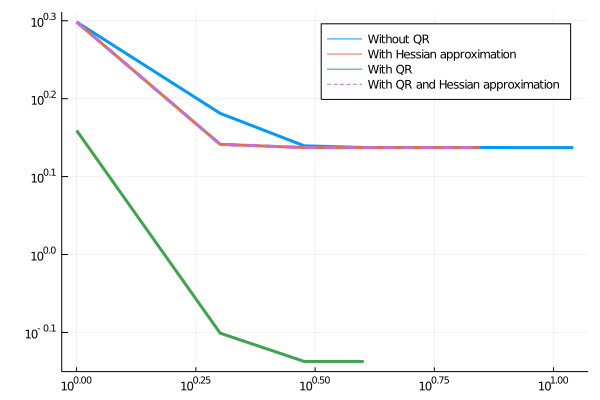

In [274]:
plot(Optim.f_trace(res), linewidth = 3, xscale = :log10, yscale = :log10, label = "Without QR")
# scatter!(Optim.f_trace(res), linewidth = 3, label = "Without QR")
plot!(Optim.f_trace(resprecond), linewidth = 3, label = "With Hessian approximation")
# scatter!(Optim.f_trace(resprecond), linewidth = 3, label = "With Hessian approximation")
plot!(Optim.f_trace(r̃es), linewidth = 3, label = "With QR")
# scatter!(Optim.f_trace(r̃es), linewidth = 3, label = "With QR")
plot!(Optim.f_trace(r̃esprecond), linewidth = 3, label = "With QR and Hessian approximation", linestyle = :dash)
# scatter!(Optim.f_trace(r̃esprecond), linewidth = 3, label = "With QR and Hessian approximation")
# savefig("comparison ")